<a href="https://colab.research.google.com/github/gustavoramos82/Predi-o-Pre-o-Carros/blob/main/Predi%C3%A7%C3%A3o_no_Pre%C3%A7o_dos_Carros_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tratamento

Agora, feito a análise exploratória, agora vai fazer o tratamento e depois a modelagem e verificar qual modelo tem a melhor perfomace.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 91 kB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt


In [ ]:
def rmse(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))

def metricas(y_true,y_pred):
  print('R2 Score:',r2_score(y_true,y_pred))
  print('MAE:',mean_absolute_error(y_true,y_pred))
  print('RMSE:',rmse(y_true,y_pred))
  print('MAPE:',mean_absolute_percentage_error(y_true,y_pred))

In [ ]:
# Importando o arquivo csv
car = pd.read_csv('car_price_prediction.csv')
car.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [ ]:
car = car[car['Price']<600000]

In [ ]:
car['Levy'].value_counts()

-       5817
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: Levy, Length: 559, dtype: int64

In [ ]:
car.drop(['ID','Levy','Drive wheels','Doors','Wheel'],axis=1,inplace=True)

In [ ]:
car.head()

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Color,Airbags
0,13328,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,Silver,12
1,16621,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,Black,8
2,8467,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Black,2
3,3607,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,White,0
4,11726,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Silver,4


In [ ]:
car['Mileage'] = car['Mileage'].str.replace('km','')
car['Mileage'] = car['Mileage'].astype(int)

In [ ]:
car['Engine volume'] = car['Engine volume'].str.replace('Turbo','')
car['Engine volume'] = car['Engine volume'].astype(float)

In [ ]:
car['Leather interior'] = car['Leather interior'].map({'No':0,'Yes':1})

In [ ]:
le = LabelEncoder()
le.fit(car['Manufacturer'])
car['Manufacturer'] = le.transform(car['Manufacturer'])

le.fit(car['Model'])
car['Model'] = le.transform(car['Model'])

le.fit(car['Category'])
car['Category'] = le.transform(car['Category'])

le.fit(car['Fuel type'])
car['Fuel type'] = le.transform(car['Fuel type'])

le.fit(car['Gear box type'])
car['Gear box type'] = le.transform(car['Gear box type'])

le.fit(car['Color'])
car['Color'] = le.transform(car['Color'])

In [ ]:
car.head()

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Color,Airbags
0,13328,31,1241,2010,4,1,2,3.5,186005,6.0,0,12,12
1,16621,8,658,2011,4,0,5,3.0,192000,6.0,2,1,8
2,8467,21,684,2006,3,0,5,1.3,200000,4.0,3,1,2
3,3607,16,661,2011,4,1,2,2.5,168966,4.0,0,14,0
4,11726,21,684,2014,3,1,5,1.3,91901,4.0,0,12,4


In [ ]:
x = car.drop('Price',axis=1)
y = car.Price

x_std = StandardScaler().fit_transform(x)

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_std,y,test_size=0.2,random_state=42)

In [ ]:
model_list = [LinearRegression(),Ridge(),KNeighborsRegressor(),DecisionTreeRegressor(),
              RandomForestRegressor(),GradientBoostingRegressor(),LGBMRegressor(),XGBRegressor()]

In [ ]:
for i in range(len(model_list)):
  cla = model_list[i]
  print(model_list[i])
  cla.fit(x_treino,y_treino)
  y_pred = cla.predict(x_teste)
  metricas(y_teste,y_pred)
  print('-*-'*10)

LinearRegression()
R2 Score: 0.19031052823718286
MAE: 10766.816781369946
RMSE: 15957.617078830825
MAPE: 19.925661292704596
-*--*--*--*--*--*--*--*--*--*-
Ridge()
R2 Score: 0.19031019368596547
MAE: 10766.73902387699
RMSE: 15957.620375551269
MAPE: 19.92621786820735
-*--*--*--*--*--*--*--*--*--*-
KNeighborsRegressor()
R2 Score: 0.540752813581229
MAE: 5865.105744736157
RMSE: 12017.995732942154
MAPE: 14.917471681105972
-*--*--*--*--*--*--*--*--*--*-
DecisionTreeRegressor()
R2 Score: 0.490711066863431
MAE: 5757.830176184519
RMSE: 12655.838169726107
MAPE: 22.27790248778025
-*--*--*--*--*--*--*--*--*--*-
RandomForestRegressor()
R2 Score: 0.7228477236775288
MAE: 4596.353559137944
RMSE: 9336.154247361543
MAPE: 15.208210424530128
-*--*--*--*--*--*--*--*--*--*-
GradientBoostingRegressor()
R2 Score: 0.5454361788074258
MAE: 7256.640852348952
RMSE: 11956.559432458462
MAPE: 18.217634439818493
-*--*--*--*--*--*--*--*--*--*-
LGBMRegressor()
R2 Score: 0.67954858406133
MAE: 5694.109801679973
RMSE: 10038.9

In [ ]:
cat = CatBoostRegressor()
cat.fit(x_treino,y_treino)
y_cat = cat.predict(x_teste)

Learning rate set to 0.063059
0:	learn: 17958.2986037	total: 15.1ms	remaining: 15.1s
1:	learn: 17548.7557802	total: 19.4ms	remaining: 9.69s
2:	learn: 17207.0808172	total: 23.4ms	remaining: 7.77s
3:	learn: 16856.9706588	total: 27.4ms	remaining: 6.81s
4:	learn: 16524.0906983	total: 31.4ms	remaining: 6.24s
5:	learn: 16237.0126907	total: 35.1ms	remaining: 5.81s
6:	learn: 15969.1581760	total: 38.8ms	remaining: 5.5s
7:	learn: 15709.3380910	total: 42.8ms	remaining: 5.31s
8:	learn: 15497.8252767	total: 46.7ms	remaining: 5.14s
9:	learn: 15307.2688818	total: 50.9ms	remaining: 5.04s
10:	learn: 15112.3215592	total: 54.7ms	remaining: 4.92s
11:	learn: 14945.3205281	total: 58.4ms	remaining: 4.81s
12:	learn: 14773.3435201	total: 62.5ms	remaining: 4.74s
13:	learn: 14613.8933464	total: 66.5ms	remaining: 4.68s
14:	learn: 14481.9805084	total: 70.3ms	remaining: 4.62s
15:	learn: 14324.8736291	total: 74.3ms	remaining: 4.57s
16:	learn: 14188.8963448	total: 83.2ms	remaining: 4.81s
17:	learn: 14080.8617774	tota

In [ ]:
metricas(y_teste,y_cat)

R2 Score: 0.6913224763568147
MAE: 5512.361102416011
RMSE: 9852.836976440003
MAPE: 13.747543554715183


In [ ]:
neural = MLPRegressor()
neural.fit(x_treino,y_treino) 
y_mlp = neural.predict(x_teste)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
metricas(y_teste,y_mlp)

R2 Score: 0.26149020166924464
MAE: 10180.5853239466
RMSE: 15240.0686819104
MAPE: 19.39591868868402


In [ ]:

rf = RandomForestRegressor()
rf.fit(x_treino,y_treino)
y_rf = rf.predict(x_teste)


Text(0, 0.5, 'Dado Predito')

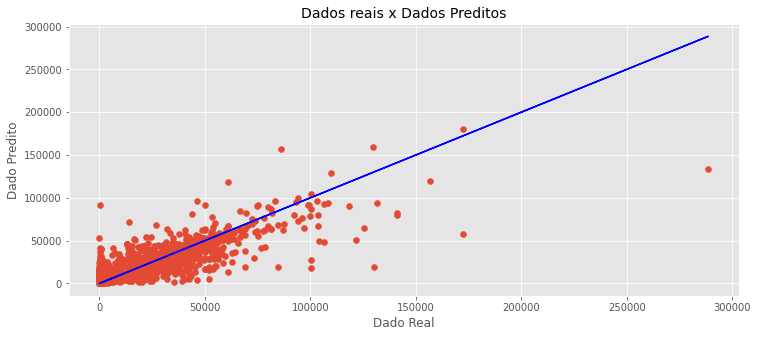

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.title('Dados reais x Dados Preditos',fontsize=14)
plt.plot(y_teste,y_teste,color='blue')
plt.scatter(y_teste,y_rf)
plt.xlabel('Dado Real')
plt.ylabel('Dado Predito')